Install Librarires

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch


Load Data

In [6]:
# Load the dataset
data_path = r'C:\Users\ali-mm\Desktop\GENed\Data_CHF_Zhao_2020_ATE.csv'
data = pd.read_csv(data_path)
data = data.drop(columns=['author','geometry'])
data = data.rename(columns={'x_e_out [-]': 'x_e_out'})
# Display the first few rows of the dataset
data.head()

,id,pressure [MPa],mass_flux [kg/m2-s],x_e_out,D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,1,0.39,5600,-0.1041,3.0,3.0,100,11.3
1,2,0.31,6700,-0.0596,3.0,3.0,100,10.6
2,3,0.33,4300,-0.0395,3.0,3.0,100,7.3
3,4,0.62,6400,-0.1460,3.0,3.0,100,12.8
4,5,0.64,4700,-0.0849,3.0,3.0,100,11.0


Exploratory Data Analysis (EDA)

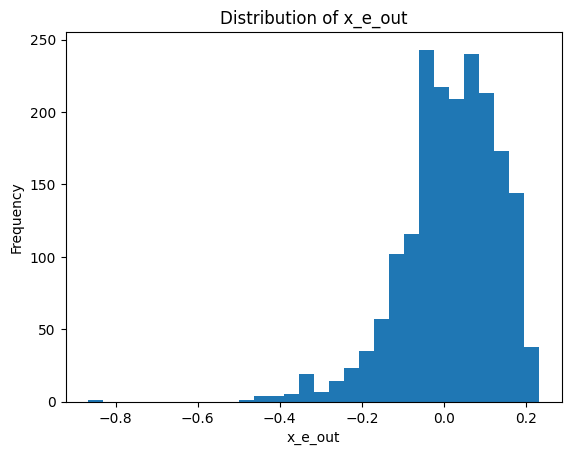

In [20]:
# Basic statistics
data.describe()

# Check for missing values
data.isnull().sum()

# Distribution of the target variable

plt.hist(data['x_e_out'], bins=30)
plt.xlabel('x_e_out')
plt.ylabel('Frequency')
plt.title('Distribution of x_e_out')
plt.show()

Data Processing

In [7]:
# Handle missing values (if any)
data = data.dropna()

# If there are categorical variables, encode them
# Assuming all variables are numerical for this task

# Normalizing the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.drop(columns=['x_e_out']))
scaled_data = pd.DataFrame(scaled_data, columns=data.columns[:-1])

# Add the target column back
scaled_data['x_e_out'] = data['x_e_out'].values

# Display the first few rows of the scaled data
scaled_data.head()

,id,pressure [MPa],mass_flux [kg/m2-s],x_e_out,D_e [mm],D_h [mm],length [mm]
0,-1.731122,-2.247063,1.653022,-0.1041,-0.621788,-1.116743,3.750806
1,-1.729265,-2.265747,2.317286,-0.0596,-0.621788,-1.116743,3.398162
2,-1.727407,-2.261076,0.867983,-0.0395,-0.621788,-1.116743,1.735696
3,-1.725550,-2.193344,2.136123,-0.1460,-0.621788,-1.116743,4.506473
4,-1.723693,-2.188673,1.109534,-0.0849,-0.621788,-1.116743,3.599673


Splitting the Data

In [8]:
# Features and target
X = scaled_data.drop(columns=['x_e_out'])
y = scaled_data['x_e_out']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to torch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([1492, 6]) torch.Size([373, 6]) torch.Size([1492, 1]) torch.Size([373, 1])


Building the Neural Network

In [9]:
nn = torch.nn

# Define the model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(X_train.shape[1], 64)
        self.layer2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.output(x)
        return x

model = NeuralNetwork()
print(model)


NeuralNetwork(
  (layer1): Linear(in_features=6, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Training the Model

In [10]:
optim = torch.optim

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [10/50], Loss: 0.0220
Epoch [20/50], Loss: 0.0141
Epoch [30/50], Loss: 0.0084
Epoch [40/50], Loss: 0.0075
Epoch [50/50], Loss: 0.0064


Prediction and Evaluation

In [13]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Make predictions
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')


RMSE: 0.0784570723772049
